In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.filters import roberts, sobel, scharr, prewitt
import math
import argparse
import time

## 图像矢量风格化

In [2]:
def psf2otf(psf, outSize=None):
  # Prepare psf for conversion
  data = prepare_psf(psf, outSize)

  # Compute the OTF
  otf = np.fft.fftn(data)

  return np.complex64(otf)

def prepare_psf(psf, outSize=None, dtype=None):
  if not dtype:
    dtype=np.float32

  psf = np.float32(psf)

  # Determine PSF / OTF shapes
  psfSize = np.int32(psf.shape)
  if not outSize:
    outSize = psfSize
  outSize = np.int32(outSize)

  # Pad the PSF to outSize
  new_psf = np.zeros(outSize, dtype=dtype)
  new_psf[:psfSize[0],:psfSize[1]] = psf[:,:]
  psf = new_psf

  # Circularly shift the OTF so that PSF center is at (0,0)
  shift = -(psfSize // 2)
  psf = circshift(psf, shift)

  return psf

# Circularly shift array
def circshift(A, shift):
  for i in range(shift.size):
    A = np.roll(A, shift[i], axis=i)
  return A

# Image File Path
def smooth(image_r,image_w = "out_serial.png",kappa = 2.0,_lambda = 0.1):


    # Verbose output
    verbose = False;

    if isinstance(image_r,str):
        image = cv2.imread(image_r)
    else:
        image = image_r
    # Timers
    step_1 = 0.0
    step_2 = 0.0
    step_2_fft = 0.0

    # Start time
    start_time = time.time()

    # Validate image format
    N, M, D = np.int32(image.shape)
    assert D == 3, "Error: input must be 3-channel RGB image"
    print("Processing %d x %d RGB image" % (M, N))

    # Initialize S as I
    S = np.float32(image) / 256

    # Compute image OTF
    size_2D = [N, M]
    fx = np.int32([[1, -1]])
    fy = np.int32([[1], [-1]])
    otfFx = psf2otf(fx, size_2D)
    otfFy = psf2otf(fy, size_2D)

    # Compute F(I)
    FI = np.complex64(np.zeros((N, M, D)))
    FI[:,:,0] = np.fft.fft2(S[:,:,0])
    FI[:,:,1] = np.fft.fft2(S[:,:,1])
    FI[:,:,2] = np.fft.fft2(S[:,:,2])

    # Compute MTF
    MTF = np.power(np.abs(otfFx), 2) + np.power(np.abs(otfFy), 2)
    MTF = np.tile(MTF[:, :, np.newaxis], (1, 1, D))

    # Initialize buffers
    h = np.float32(np.zeros((N, M, D)))
    v = np.float32(np.zeros((N, M, D)))
    dxhp = np.float32(np.zeros((N, M, D)))
    dyvp = np.float32(np.zeros((N, M, D)))
    FS = np.complex64(np.zeros((N, M, D)))

    # Iteration settings
    beta_max = 1e5;
    beta = 2 * _lambda
    iteration = 0

    # Done initializing  
    init_time = time.time()

    # Iterate until desired convergence in similarity
    while beta < beta_max:
        if verbose:
          print("ITERATION %i" % iteration)

        ### Step 1: estimate (h, v) subproblem

        # subproblem 1 start time
        s_time = time.time()

        # compute dxSp
        h[:,0:M-1,:] = np.diff(S, 1, 1)
        h[:,M-1:M,:] = S[:,0:1,:] - S[:,M-1:M,:]

        # compute dySp
        v[0:N-1,:,:] = np.diff(S, 1, 0)
        v[N-1:N,:,:] = S[0:1,:,:] - S[N-1:N,:,:]

        # compute minimum energy E = dxSp^2 + dySp^2 <= _lambda/beta
        t = np.sum(np.power(h, 2) + np.power(v, 2), axis=2) < _lambda / beta
        t = np.tile(t[:, :, np.newaxis], (1, 1, 3))

        # compute piecewise solution for hp, vp
        h[t] = 0
        v[t] = 0

        # subproblem 1 end time
        e_time = time.time()
        step_1 = step_1 + e_time - s_time
        if verbose:
          print("-subproblem 1: estimate (h,v)")
          print("--time: %f (s)" % (e_time - s_time))

        ### Step 2: estimate S subproblem

        # subproblem 2 start time
        s_time = time.time()

        # compute dxhp + dyvp
        dxhp[:,0:1,:] = h[:,M-1:M,:] - h[:,0:1,:]
        dxhp[:,1:M,:] = -(np.diff(h, 1, 1))
        dyvp[0:1,:,:] = v[N-1:N,:,:] - v[0:1,:,:]
        dyvp[1:N,:,:] = -(np.diff(v, 1, 0))
        normin = dxhp + dyvp

        fft_s = time.time()
        FS[:,:,0] = np.fft.fft2(normin[:,:,0])
        FS[:,:,1] = np.fft.fft2(normin[:,:,1])
        FS[:,:,2] = np.fft.fft2(normin[:,:,2])
        fft_e = time.time()
        step_2_fft += fft_e - fft_s

        # solve for S + 1 in Fourier domain
        denorm = 1 + beta * MTF;
        FS[:,:,:] = (FI + beta * FS) / denorm

        # inverse FFT to compute S + 1
        fft_s = time.time()
        S[:,:,0] = np.float32((np.fft.ifft2(FS[:,:,0])).real)
        S[:,:,1] = np.float32((np.fft.ifft2(FS[:,:,1])).real)
        S[:,:,2] = np.float32((np.fft.ifft2(FS[:,:,2])).real)
        fft_e = time.time()
        step_2_fft += fft_e - fft_s

        # subproblem 2 end time
        e_time = time.time()
        step_2 =  step_2 + e_time - s_time
        if verbose:
          print("-subproblem 2: estimate S + 1")
          print("--time: %f (s)" % (e_time - s_time))

        # update beta for next iteration
        beta *= kappa
        iteration += 1

    # Rescale image
    S = S * 256

    # Total end time
    final_time = time.time()

    print("Total Time: %f (s)" % (final_time - start_time))
    print("Setup: %f (s)" % (init_time - start_time))
    print("Step 1: %f (s)" % (step_1))
    print("Step 2: %f (s)" % (step_2))
    print("Step 2 (FFT): %f (s)" % (step_2_fft))
    print("Iterations: %d" % (iteration))

    return np.uint8(S)


In [32]:
img = cv2.imread('./scu.jpg',0)
# N, M, D = np.int32(img.shape)
# fx = np.int32([[1, -1]])
# fy = np.int32([[1], [-1]])
# otfFx = psf2otf(fx, (N,M))
# otfFy = psf2otf(fy, (N,M))

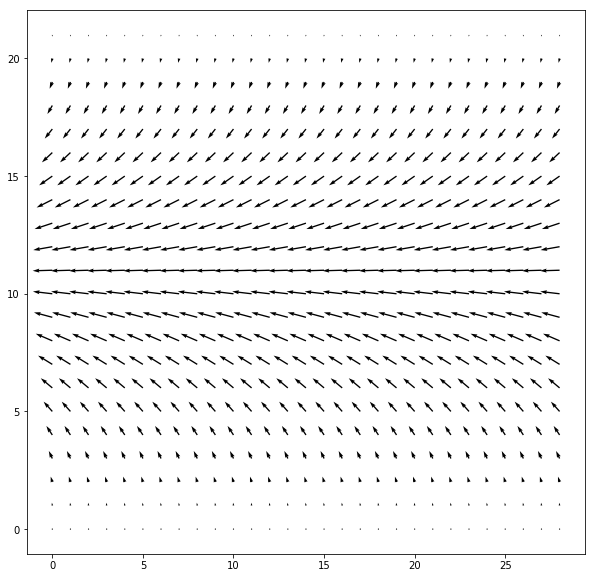

In [29]:
plt.figure(figsize=(10,10))
plt.quiver(np.real(otfFy[::50,::50]),np.imag(otfFy[::50,::50]))
plt.savefig('otfY')

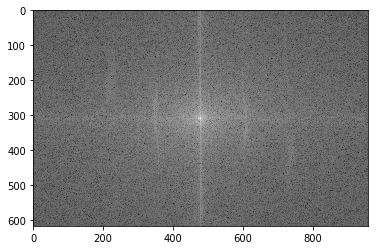

In [55]:
ff = cv2.dft(np.float32(img),flags = cv2.DFT_COMPLEX_OUTPUT)
ffr = np.fft.fftshift(ff)
at = cv2.magnitude(ffr[:,:,0],ffr[:,:,1])
at = np.log(at)
at = np.fabs(at)
plt.imshow(at,'gray')
plt.savefig('fft.jpg')

In [51]:
ffr[]

(618, 959)

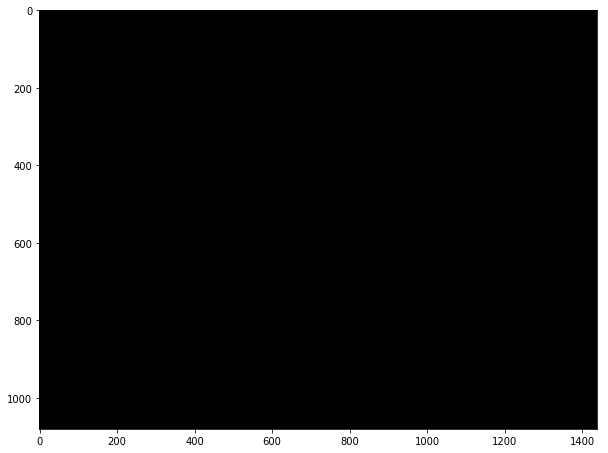

In [376]:
plt.figure(figsize=(10,10))
plt.imshow(rgb)

True

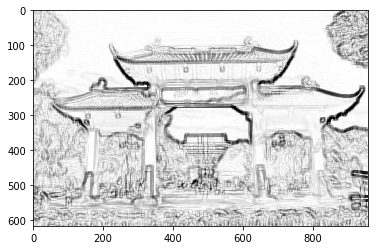

In [71]:
gray = cv2.imread('./scu_raw.jpg',0)
gray = cv2.blur(gray,(11,11))
edge_x = cv2.Sobel(gray, cv2.CV_64F,dx=0,dy=1,ksize=3)
edge_y = cv2.Sobel(gray, cv2.CV_64F,dx=1,dy=0,ksize=3)
edge_val = (np.fabs(edge_x/255)+np.fabs(edge_y/255))*1.2
edge_val[edge_val>1] = 1
edge_val = np.uint8((1- edge_val)*255)
plt.imshow(edge_val,'gray')
cv2.imwrite('scu5-eg.jpg',edge_val)

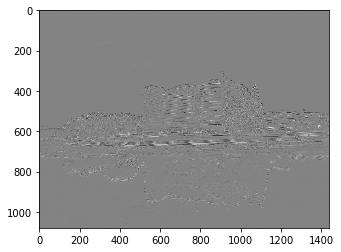

In [343]:
plt.imshow(edge_x,'gray')

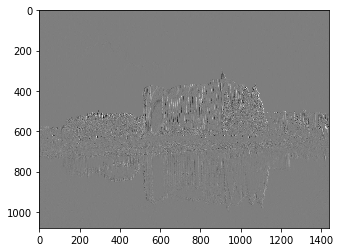

In [344]:
plt.imshow(edge_y,'gray')

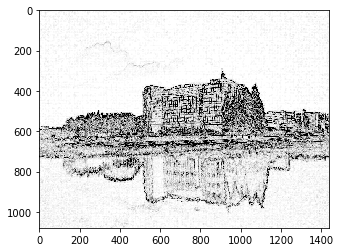

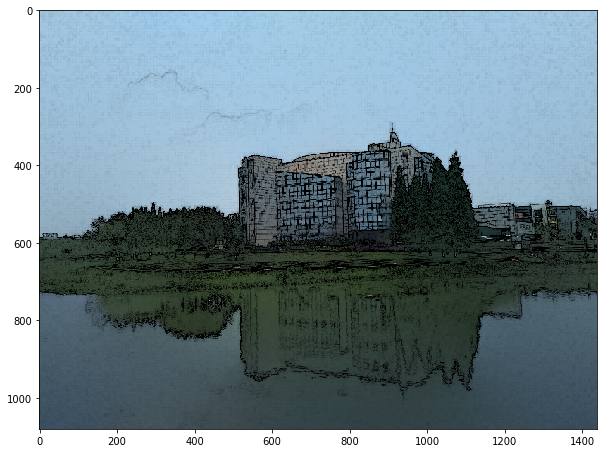

In [346]:
edg = np.zeros(img.shape)
for i in range(3):
    edg[:,:,i] = edge_val.copy()
tt = np.uint8(rgb*edg)
fg = plt.figure(figsize=(10,10))
plt.imshow(tt)

In [227]:
rgb,tt

(array([[[124, 157,  52],
         [124, 157,  52],
         [124, 157,  52],
         ...,
         [193, 201, 222],
         [191, 202, 224],
         [191, 202, 224]],
 
        [[124, 157,  52],
         [124, 157,  52],
         [124, 157,  52],
         ...,
         [193, 201, 222],
         [191, 202, 222],
         [190, 201, 221]],
 
        [[124, 157,  52],
         [124, 157,  52],
         [124, 157,  52],
         ...,
         [193, 201, 220],
         [193, 201, 220],
         [192, 200, 219]],
 
        ...,
 
        [[ 97,  86,  56],
         [ 95,  84,  54],
         [ 91,  81,  54],
         ...,
         [105, 100,  44],
         [104,  99,  44],
         [102,  97,  42]],
 
        [[ 98,  87,  57],
         [ 96,  85,  55],
         [ 92,  82,  55],
         ...,
         [104,  99,  43],
         [104,  99,  44],
         [103,  98,  43]],
 
        [[ 99,  88,  58],
         [ 97,  86,  56],
         [ 92,  82,  55],
         ...,
         [104,  99,  43],
  

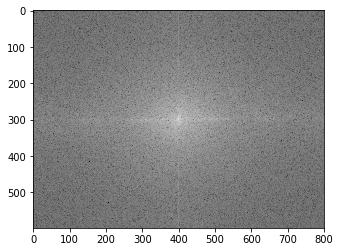

In [190]:
f_r = cv2.dft(np.float32(edge_val),flags=cv2.DFT_COMPLEX_OUTPUT)
dft_shift = np.fft.fftshift(f_r)
e = 20*np.log(cv2.magnitude(dft_shift[:,:,0],dft_shift[:,:,1]))
e = cv2.normalize(e,0,255)
plt.imshow(e,'gray')

In [184]:
dft_shift

array([[[ 3.8146973e-06,  5.6569092e+01],
        [ 2.4766132e+01, -7.7049858e+01],
        [-6.7052155e+01,  6.7595444e+00],
        ...,
        [-8.6166466e+01,  3.6033699e+01],
        [ 6.7052155e+01,  6.7595444e+00],
        [-2.4766132e+01, -7.7049858e+01]],

       [[-1.7100370e+01,  6.3103287e+01],
        [-5.9413357e+00,  4.5953098e+01],
        [ 1.0010641e+01,  4.3089642e+01],
        ...,
        [-2.2122326e+01, -3.5491520e+01],
        [-3.8294174e+01, -2.7319641e+01],
        [ 4.5800240e+01, -7.9631414e+00]],

       [[-4.2738342e+01, -1.2700081e+01],
        [-5.7978210e+00,  9.5775604e-02],
        [ 3.3753929e+01,  4.5598663e+01],
        ...,
        [-5.3211674e+01, -5.3362637e+01],
        [-1.8468662e+01,  1.2883081e+02],
        [-6.8724342e+01, -3.9513264e+01]],

       ...,

       [[-8.5985092e+01,  4.0653511e+01],
        [ 5.3166023e+01,  3.5381103e+00],
        [ 2.2886209e+01,  5.9197662e+01],
        ...,
        [ 5.8105640e+01,  3.4855484e+01],
     